# Model Output Data Visualization

### Read Me

This notebook vizualizes model outputs for supervised neural methods from the rPPG Toolbox. To use this notebook follow the following steps:

* STEP 1: Specify the `TEST.OUTPUT_SAVE_DIR` field in the `.yaml` config file of a neural method experiment.
* STEP 2: Run the neural method experiment. A `.pickle` file containing the test-data predictions and labels will be created in `TEST.OUTPUT_SAVE_DIR`.
* STEP 3: Add the path to the `pickle` file in the `TODO: Variable to Set` section as `data_out_path`.
* STEP 4: Add values for `trial_idx` (a value between 0 and the `Num Trials` print in the previous cell), `chunk_size` (number of samples to plot out), `chunk_num` (the chunk of size `chunk_size` in the signal). We suggest using the defaults at first.
* STEP 5: Run all cells. The predicted output, plotted against the ground truth ppg waveform, will be plotted in the final cell

### Imports

In [3]:
# !pip install natsort
!pip install scipy
# !pip install natsort
# !pip install ipywidgets

import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import re

import torch

import numpy as np
# import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

### Helper Functions

In [4]:
# HELPER FUNCTIONS

def _reform_data_from_dict(data, flatten=True):
    """Helper func for calculate metrics: reformat predictions and labels from dicts. """
    sort_data = sorted(data.items(), key=lambda x: x[0])
    sort_data = [i[1] for i in sort_data]
    sort_data = torch.cat(sort_data, dim=0)

    if flatten:
        sort_data = np.reshape(sort_data.cpu(), (-1))
    else:
        sort_data = np.array(sort_data.cpu())

    return sort_data

def _process_signal(signal, fs=30, diff_flag=True):
    # Detrend and filter
    use_bandpass = True
    if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
        gt_bvp = _detrend(np.cumsum(signal), 100)
    else:
        gt_bvp = _detrend(signal, 100)
    if use_bandpass:
        # bandpass filter between [0.75, 2.5] Hz
        # equals [45, 150] beats per min
        [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
        signal = scipy.signal.filtfilt(b, a, np.double(signal))
    return signal

def _detrend(input_signal, lambda_value):
    """Detrend PPG signal."""
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal


### TODO: Variables To Set

In [10]:
trial_list

['subject10',
 'subject11',
 'subject12',
 'subject13',
 'subject14',
 'subject15',
 'subject16',
 'subject17',
 'subject18',
 'subject1',
 'subject20',
 'subject22',
 'subject23',
 'subject24',
 'subject25',
 'subject26',
 'subject27',
 'subject30',
 'subject31',
 'subject32',
 'subject33',
 'subject34',
 'subject35',
 'subject36',
 'subject37',
 'subject38',
 'subject39',
 'subject3',
 'subject40',
 'subject41',
 'subject42',
 'subject43',
 'subject44',
 'subject45',
 'subject46',
 'subject47',
 'subject48',
 'subject49',
 'subject4',
 'subject5',
 'subject8',
 'subject9']

In [5]:
data_out_path = "/home/nataly/rPPG-Toolbox/runs/exp/UBFC-rPPG_SizeW128_SizeH128_ClipLength160_DataTypeStandardized_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/PURE_RhythmFormer_UBFC-rPPG_outputs.pickle"  # Output Data Path 
trial_idx = 0
chunk_size = 180 # size of chunk to visualize: -1 will plot the entire signal
chunk_num = 0

### Read Data, and Extract Trials List

In [6]:
# Read in data and list subjects
with open(data_out_path, 'rb') as f:
    data = pickle.load(f)
    
# List of all video trials
trial_list = list(data['predictions'].keys())
print('Num Trials', len(trial_list))

Num Trials 42


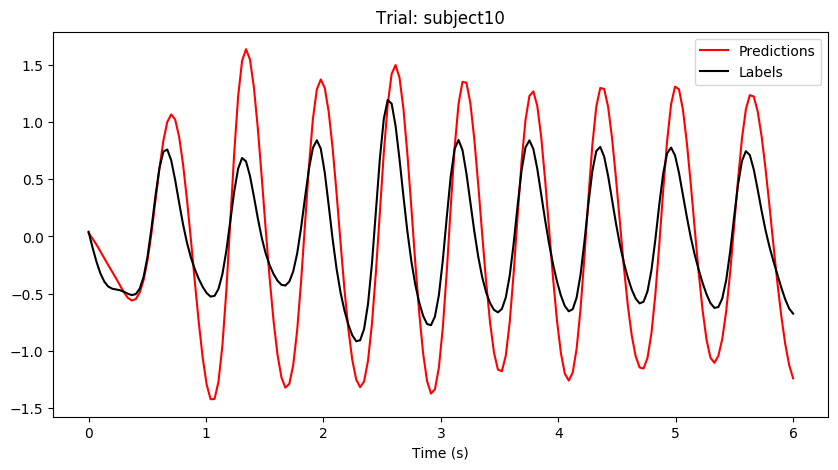

In [7]:
# Reform label and prediction vectors from multiple trial chunks
prediction = np.array(_reform_data_from_dict(data['predictions'][trial_list[trial_idx]]))
label = np.array(_reform_data_from_dict(data['labels'][trial_list[trial_idx]]))

# Read in meta-data from pickle file
fs = data['fs'] # Video Frame Rate
label_type = data['label_type'] # PPG Signal Transformation: `DiffNormalized` or `Standardized`
diff_flag = (label_type == 'DiffNormalized')

if chunk_size == -1:
    chunk_size = len(prediction)
    chunk_num = 0

# Process label and prediction signals
prediction = _process_signal(prediction, fs, diff_flag=diff_flag)
label = _process_signal(label, fs, diff_flag=diff_flag)
start = (chunk_num)*chunk_size
stop = (chunk_num+1)*chunk_size
samples = stop - start
x_time = np.linspace(0, samples/fs, num=samples)

plt.figure(figsize=(10,5))
plt.plot(x_time, prediction[start:stop], color='r')
plt.plot(x_time, label[start:stop], color='black')
plt.title('Trial: ' + trial_list[trial_idx])
plt.legend(['Predictions', 'Labels'])
plt.xlabel('Time (s)');